{'0': 'Ace', '1': 'Akainu', '2': 'Brook', '3': 'Chopper', '4': 'Crocodile', '5': 'Franky', '6': 'Jinbei', '7': 'Kurohige', '8': 'Law', '9': 'Luffy', '10': 'Mihawk', '11': 'Nami', '12': 'Rayleigh', '13': 'Robin', '14': 'Sanji', '15': 'Shanks', '16': 'Usopp', '17': 'Zoro'}


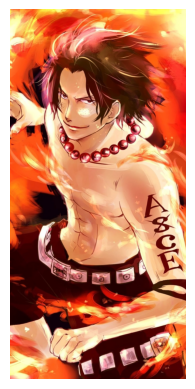

In [102]:
import os
import json
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.metrics import f1_score
from tqdm import tqdm
import torch
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torchvision.models import resnet18


train_dir = 'train'
test_dir = 'test'
labels_path = 'labels.json'
with open(labels_path, 'r') as f:
    labels = json.load(f)
print(labels)
sample_image_path = os.path.join(train_dir, 'Ace/1.jpg')
image = Image.open(sample_image_path)
plt.imshow(image)
plt.axis('off')
plt.show()

In [104]:
with open(labels_path, 'r') as f:
    labels = json.load(f)
print(labels)

{'0': 'Ace', '1': 'Akainu', '2': 'Brook', '3': 'Chopper', '4': 'Crocodile', '5': 'Franky', '6': 'Jinbei', '7': 'Kurohige', '8': 'Law', '9': 'Luffy', '10': 'Mihawk', '11': 'Nami', '12': 'Rayleigh', '13': 'Robin', '14': 'Sanji', '15': 'Shanks', '16': 'Usopp', '17': 'Zoro'}


In [106]:
class OnePieceDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.classes = sorted(os.listdir(root_dir)) 
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}
        for cls_name in self.classes:
            cls_dir = os.path.join(root_dir, cls_name)
            if os.path.isdir(cls_dir):
                for img_name in os.listdir(cls_dir):
                    img_path = os.path.join(cls_dir, img_name)
                    self.image_paths.append(img_path)
                    self.labels.append(self.class_to_idx[cls_name])
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        
        return image, label
from torchvision import transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
train_dir = 'train'
train_dataset = OnePieceDataset(train_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

for images, labels in train_loader:
    print(f"Batch size: {images.size(0)}, Image shape: {images.size()}, Labels: {labels}")
    break

Batch size: 32, Image shape: torch.Size([32, 3, 224, 224]), Labels: tensor([ 2, 17,  3,  3,  6, 14, 12,  1,  8, 16,  8,  4, 17, 10, 16,  6,  5, 16,
        16, 12,  2, 17, 14,  3, 11,  6, 15, 10,  1,  8,  8, 17])


In [108]:
train_dir = 'train'
train_dataset = OnePieceDataset(train_dir)

train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_dataset.image_paths, train_dataset.labels, test_size=0.2, random_state=42, stratify=train_dataset.labels
)

class OnePieceAugmentedDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

In [110]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [112]:
train_data = OnePieceAugmentedDataset(train_paths, train_labels, transform=train_transform)
val_data = OnePieceAugmentedDataset(val_paths, val_labels, transform=val_transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

In [56]:
from torchvision.models import resnet18
import torch.nn as nn
import torch.optim as optim

model = resnet18(pretrained=True)
num_classes = 18 
model.fc = nn.Linear(model.fc.in_features, num_classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/anastasiavinogradskaa/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████████████████████████████████| 44.7M/44.7M [00:03<00:00, 12.3MB/s]


In [60]:
import time

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    start_time = time.time() 

    for batch_idx, (images, labels) in enumerate(train_loader, start=1):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if batch_idx % 10 == 0:  
            print(f"[Epoch {epoch+1}/{num_epochs}] Batch {batch_idx}/{len(train_loader)} - "
                  f"Loss: {loss.item():.4f}")

    epoch_time = time.time() - start_time  # Время выполнения эпохи
    print(f"Epoch {epoch+1}/{num_epochs} completed in {epoch_time:.2f} seconds. "
          f"Average Loss: {running_loss/len(train_loader):.4f}")

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Validation Loss: {val_loss/len(val_loader):.4f}, Accuracy: {correct/total:.4f}")

[Epoch 1/10] Batch 10/73 - Loss: 3.3355


/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[Epoch 1/10] Batch 20/73 - Loss: 2.2250
[Epoch 1/10] Batch 30/73 - Loss: 1.9981
[Epoch 1/10] Batch 40/73 - Loss: 1.8154
[Epoch 1/10] Batch 50/73 - Loss: 2.2735
[Epoch 1/10] Batch 60/73 - Loss: 1.8591
[Epoch 1/10] Batch 70/73 - Loss: 1.7307
Epoch 1/10 completed in 895.40 seconds. Average Loss: 2.1377
Validation Loss: 1.7917, Accuracy: 0.4357
[Epoch 2/10] Batch 10/73 - Loss: 1.2563
[Epoch 2/10] Batch 20/73 - Loss: 1.3015
[Epoch 2/10] Batch 30/73 - Loss: 1.8138
[Epoch 2/10] Batch 40/73 - Loss: 2.0121
[Epoch 2/10] Batch 50/73 - Loss: 1.6838
[Epoch 2/10] Batch 60/73 - Loss: 1.2902
[Epoch 2/10] Batch 70/73 - Loss: 2.0083
Epoch 2/10 completed in 994.10 seconds. Average Loss: 1.5135
Validation Loss: 2.2249, Accuracy: 0.3962
[Epoch 3/10] Batch 10/73 - Loss: 1.3583
[Epoch 3/10] Batch 20/73 - Loss: 1.7789
[Epoch 3/10] Batch 30/73 - Loss: 1.8184
[Epoch 3/10] Batch 40/73 - Loss: 1.5999
[Epoch 3/10] Batch 50/73 - Loss: 1.0403
[Epoch 3/10] Batch 60/73 - Loss: 1.2199
[Epoch 3/10] Batch 70/73 - Loss: 1

In [114]:
class OnePieceDataset(Dataset):
    def __init__(self, root_dir, transform=None, test_mode=False):
        self.root_dir = root_dir
        self.transform = transform
        self.test_mode = test_mode
        self.image_paths = []

        if test_mode:
            self.image_paths = [os.path.join(root_dir, img_name) for img_name in os.listdir(root_dir)]
        else:
            self.labels = []
            self.classes = sorted(os.listdir(root_dir))
            self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}

            for cls_name in self.classes:
                cls_dir = os.path.join(root_dir, cls_name)
                if os.path.isdir(cls_dir):
                    for img_name in os.listdir(cls_dir):
                        img_path = os.path.join(cls_dir, img_name)
                        self.image_paths.append(img_path)
                        self.labels.append(self.class_to_idx[cls_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        if self.test_mode:
            file_name = os.path.basename(img_path).split('.')[0] 
            return image, file_name
        else:
            label = self.labels[idx]
            return image, label
test_dataset = OnePieceDataset(root_dir=test_dir, transform=transform, test_mode=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
import pandas as pd
model.eval()
predictions = []

with torch.no_grad():
    for images, file_names in test_loader: 
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        for file_name, label in zip(file_names, predicted.cpu().numpy()):
            predictions.append({'id': file_name, 'label': label})
submission_df = pd.DataFrame(predictions)
submission_df.to_csv('submission.csv', index=False)

In [ ]:
from torchvision.models import resnet18
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau


model = resnet18(pretrained=True)

model.fc = nn.Sequential(
    nn.Dropout(0.5), 
    nn.Linear(model.fc.in_features, num_classes)
)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=10) 

num_epochs = 20

In [78]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    start_time = time.time()

    for batch_idx, (images, labels) in enumerate(train_loader, start=1):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if batch_idx % 10 == 0:  # Печатаем каждые 10 батчей
            print(f"[Epoch {epoch+1}/{num_epochs}] Batch {batch_idx}/{len(train_loader)} - "
                  f"Loss: {loss.item():.4f}")

    scheduler.step()

    epoch_time = time.time() - start_time  # Время выполнения эпохи
    print(f"Epoch {epoch+1}/{num_epochs} completed in {epoch_time:.2f} seconds. "
          f"Average Loss: {running_loss/len(train_loader):.4f}")

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = correct / total
    print(f"Validation Loss: {val_loss/len(val_loader):.4f}, Accuracy: {val_accuracy:.4f}")

    if epoch == 0 or val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), "best_resnet18.pth")
        print(f"Model saved with accuracy: {val_accuracy:.4f}")

/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[Epoch 1/20] Batch 10/73 - Loss: 2.3962
[Epoch 1/20] Batch 20/73 - Loss: 1.9886
[Epoch 1/20] Batch 30/73 - Loss: 2.4849
[Epoch 1/20] Batch 40/73 - Loss: 2.1334
[Epoch 1/20] Batch 50/73 - Loss: 1.8073
[Epoch 1/20] Batch 60/73 - Loss: 1.7136
[Epoch 1/20] Batch 70/73 - Loss: 2.1297
Epoch 1/20 completed in 923.44 seconds. Average Loss: 2.2474
Validation Loss: 3.4046, Accuracy: 0.2487
Model saved with accuracy: 0.2487
[Epoch 2/20] Batch 10/73 - Loss: 1.3422
[Epoch 2/20] Batch 20/73 - Loss: 1.7057
[Epoch 2/20] Batch 30/73 - Loss: 1.2823
[Epoch 2/20] Batch 40/73 - Loss: 1.7420
[Epoch 2/20] Batch 50/73 - Loss: 1.5240
[Epoch 2/20] Batch 60/73 - Loss: 2.0946
[Epoch 2/20] Batch 70/73 - Loss: 1.5862
Epoch 2/20 completed in 880.23 seconds. Average Loss: 1.7045
Validation Loss: 2.3677, Accuracy: 0.3997
Model saved with accuracy: 0.3997
[Epoch 3/20] Batch 10/73 - Loss: 1.3675
[Epoch 3/20] Batch 20/73 - Loss: 1.5231
[Epoch 3/20] Batch 30/73 - Loss: 1.2413
[Epoch 3/20] Batch 40/73 - Loss: 1.4482
[Epoch

In [ ]:
import pandas as pd
import os

model.eval()
predictions = []

with torch.no_grad():
    for images, file_names in test_loader: 
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1) 
        for file_name, label in zip(file_names, predicted.cpu().numpy()):
            base_name = os.path.splitext(file_name)[0]
            predictions.append({'id': base_name, 'label': label})

submission_df = pd.DataFrame(predictions)
submission_df.to_csv('submission.csv', index=False) 

In [88]:
import torchvision.transforms as transforms

class OnePieceDataset(Dataset):
    def __init__(self, root_dir):
        self.image_paths, self.labels = self._load_data(root_dir)
    def _load_data(self, root_dir):
        import os
        image_paths = []
        labels = []
        class_to_idx = {cls_name: idx for idx, cls_name in enumerate(sorted(os.listdir(root_dir)))}
        valid_extensions = ['*.jpg', '*.jpeg', '*.png', '*.bmp', '*.tiff']  
        for cls_name, cls_idx in class_to_idx.items():
            cls_folder = Path(root_dir) / cls_name
            for ext in valid_extensions:
                for img_file in cls_folder.glob(ext):
                    image_paths.append(str(img_file))
                    labels.append(cls_idx)
        return image_paths, labels

    def __len__(self):
        return len(self.image_paths)
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB") 
        return image, label
train_dir = 'train'
train_dataset = OnePieceDataset(train_dir)

train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_dataset.image_paths, train_dataset.labels, test_size=0.2, random_state=42, stratify=train_dataset.labels
)
class OnePieceAugmentedDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
train_data = OnePieceAugmentedDataset(train_paths, train_labels, transform=train_transform)
val_data = OnePieceAugmentedDataset(val_paths, val_labels, transform=val_transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False, num_workers=0)


/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/15: Train Loss: 2.3801, Val Loss: 2.0695, Val Accuracy: 0.4014, Time: 942.25s
Model saved with accuracy: 0.4014
Epoch 2/15: Train Loss: 1.7990, Val Loss: 1.7635, Val Accuracy: 0.5420, Time: 785.05s
Model saved with accuracy: 0.5420
Epoch 3/15: Train Loss: 1.4641, Val Loss: 1.8483, Val Accuracy: 0.4854, Time: 791.34s
Epoch 4/15: Train Loss: 1.2765, Val Loss: 1.0291, Val Accuracy: 0.6895, Time: 802.97s
Model saved with accuracy: 0.6895
Epoch 5/15: Train Loss: 1.0786, Val Loss: 0.9233, Val Accuracy: 0.7221, Time: 819.15s
Model saved with accuracy: 0.7221
Epoch 6/15: Train Loss: 0.8963, Val Loss: 0.9092, Val Accuracy: 0.7547, Time: 816.97s
Model saved with accuracy: 0.7547
Epoch 7/15: Train Loss: 0.7626, Val Loss: 0.7453, Val Accuracy: 0.8027, Time: 805.38s
Model saved with accuracy: 0.8027
Epoch 8/15: Train Loss: 0.6586, Val Loss: 0.5430, Val Accuracy: 0.8439, Time: 827.64s
Model saved with accuracy: 0.8439
Epoch 9/15: Train Loss: 0.5728, Val Loss: 0.4672, Val Accuracy: 0.8714, Ti

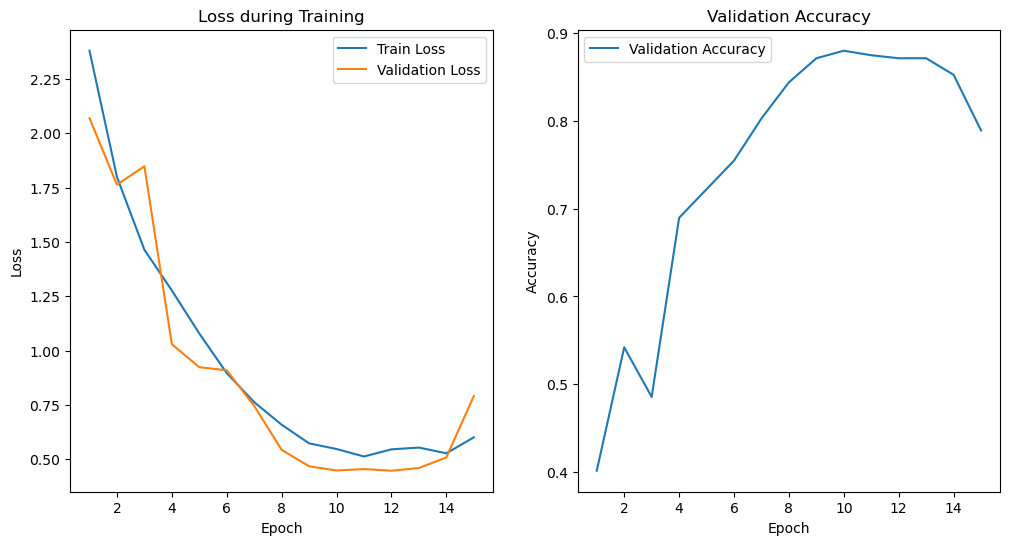

In [90]:
model = resnet18(pretrained=True)

num_classes = len(set(train_labels))  # Определяем число классов
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(model.fc.in_features, num_classes)
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=10)


results = {"epoch": [], "train_loss": [], "val_loss": [], "val_accuracy": [], "epoch_time": []}
num_epochs = 15
best_val_accuracy = 0.0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    start_time = time.time()
    for batch_idx, (images, labels) in enumerate(train_loader, start=1):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    scheduler.step()
    train_loss = running_loss / len(train_loader)
    
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = correct / total


    epoch_time = time.time() - start_time
    results["epoch"].append(epoch + 1)
    results["train_loss"].append(train_loss)
    results["val_loss"].append(val_loss)
    results["val_accuracy"].append(val_accuracy)
    results["epoch_time"].append(epoch_time)

    print(f"Epoch {epoch + 1}/{num_epochs}: "
          f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
          f"Val Accuracy: {val_accuracy:.4f}, Time: {epoch_time:.2f}s")

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), "best_resnet18.pth")
        print(f"Model saved with accuracy: {val_accuracy:.4f}")


df_results = pd.DataFrame(results)
df_results.to_csv("training_results.csv", index=False)


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(results["epoch"], results["train_loss"], label="Train Loss")
plt.plot(results["epoch"], results["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss during Training")

plt.subplot(1, 2, 2)
plt.plot(results["epoch"], results["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Validation Accuracy")
plt.savefig("training_plots.png")
plt.show()

In [92]:
import pandas as pd
import os
import torch
best_model_path = 'best_resnet18.pth'

model.load_state_dict(torch.load(best_model_path, map_location=device))  
model.to(device)  
model.eval()  
predictions = []
with torch.no_grad():
    for images, file_names in test_loader:  
        images = images.to(device) 
        outputs = model(images)  
        _, predicted = torch.max(outputs, 1)

        for file_name, label in zip(file_names, predicted.cpu().numpy()):
            base_name = os.path.splitext(file_name)[0]
            predictions.append({'id': base_name, 'label': label})

submission_df = pd.DataFrame(predictions)
submission_df.to_csv('submission.csv', index=False)  
print(submission_df.head())

/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Файл submission.csv успешно создан!
                                     id  label
0  dd6aaefa-69cd-4160-a2f6-fd10f1d94aa4     15
1  d41cd6bf-0599-4496-bbb2-12d57463d854      2
2  fe80fd31-7221-46b8-9667-8f4292a899c3      1
3  2ed52c53-c7fa-495f-83b5-2a8ffd3ef618      1
4  1ddb6183-74fe-4ae6-989d-1333f5d7cc52      5
